In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

import pymc3 as pm
import arviz as az


import os # move around in file system
import pandas as pd # read many different data file formats out there (e.g. csv, xlsx, json)

In [2]:
#%matplotlib notebook

In [4]:
MEG_df = pd.read_csv(
    'BetaPower_DAI_SSRT.csv')

In [5]:
MEG_df

,Beta_rIFG_success,Beta_preSMA_success,Beta_rIFG_fail,Beta_preSMA_fail,DAI,SSRT
0,0.257010,0.26202,0.43645,0.51019,0.351910,287.7826
1,0.358390,0.61962,0.29001,0.48054,-0.108710,250.2935
2,0.394220,0.44007,0.42282,0.62463,0.328540,305.0143
3,0.894390,0.42387,0.69665,0.45515,0.276980,211.8598
4,0.429080,0.47120,0.61075,0.41843,0.094609,216.2741
5,0.355070,0.29184,0.26828,0.28166,-0.070510,259.4964
6,0.486810,0.18566,0.24981,0.24127,0.490160,230.4130
7,0.393800,0.35623,0.25495,0.25084,0.374330,207.4481
8,0.233860,0.34924,0.23799,0.18461,0.006590,300.9676
9,0.459770,0.56096,0.50475,0.93267,0.436870,169.4167


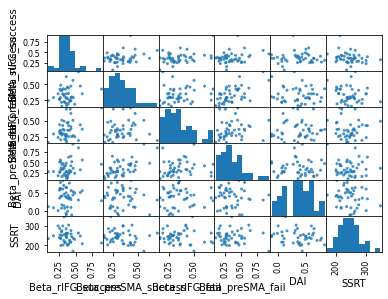

In [6]:
pd.plotting.scatter_matrix(MEG_df, alpha=0.8);

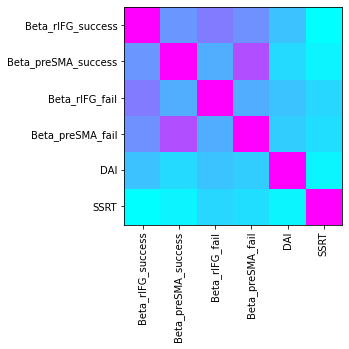

In [7]:
# correlation matrix & plot it as a heatmap:
corr_pearson = MEG_df.corr() # meg is your pandas dataframe

plt.xticks(ticks=np.arange(corr_pearson.shape[1]), labels=corr_pearson.keys(),rotation=90)
plt.yticks(ticks=np.arange(corr_pearson.shape[1]), labels=corr_pearson.keys())
plt.imshow(corr_pearson, cmap='cool',interpolation="nearest")

In [9]:
def standardize(data):
    data_z = (data - np.mean(data))/np.std(data)
    return data_z

In [10]:
# normalize everything
Beta_rIFG_success_z = standardize(MEG_df["Beta_rIFG_success"].values[:])
Beta_preSMA_success_z = standardize(MEG_df["Beta_preSMA_success"].values[:])
Beta_rIFG_fail_z = standardize(MEG_df["Beta_rIFG_fail"].values[:])
Beta_preSMA_fail_z = standardize(MEG_df["Beta_preSMA_fail"].values[:])
DAI_z = standardize(MEG_df["DAI"].values[:])
SSRT_z = standardize(MEG_df["SSRT"].values[:]) # Note: reaction times are lognormal distributed

In [11]:
Beta_preSMA_lumped_z = (np.abs(Beta_preSMA_success_z) + np.abs(Beta_preSMA_fail_z))/2

### Model with main effects for all predictors, but lumped for preSMA-variables

In [12]:
with pm.Model() as MEG_multi_lumped:
    alpha = pm.Normal("alpha", 0,0.5)
    beta_IFG_s = pm.Normal("beta_IFG_s", 0,0.5)
    beta_preSMA_l = pm.Normal("beta_preSMA_l",0,0.5)
    beta_IFG_f = pm.Normal("beta_IFG_f", 0,0.5)
    beta_DAI = pm.Normal("beta_DAI", 0,0.5)
    sigma_est = pm.HalfNormal("sigma_est", sd = 1)
    
    SSRT_z_deterministic = (alpha
                          + beta_IFG_s * Beta_rIFG_success_z
                          + beta_preSMA_l * Beta_preSMA_lumped_z
                          + beta_IFG_f * Beta_rIFG_fail_z
                          + beta_DAI * DAI_z)
    
    SSR_z_modeled = pm.Normal("SSR_z_modeled", mu = SSRT_z_deterministic, sigma = sigma_est, observed = SSRT_z)

In [13]:
with MEG_multi_lumped:
    trace_lumped = pm.sample(20000, tune=2000, init="adapt_diag")

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_est, beta_DAI, beta_IFG_f, beta_preSMA_l, beta_IFG_s, alpha]
Sampling 2 chains, 0 divergences: 100%|██████████| 44000/44000 [00:42<00:00, 1027.02draws/s]


In [14]:
with MEG_multi_lumped:
    MEG_multi_lumped_loo = pm.loo(trace_lumped, MEG_multi_lumped)
MEG_multi_lumped_loo

Computed from 40000 by 43 log-likelihood matrix

       Estimate       SE
IC_loo   129.20    10.63
p_loo      5.27        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       42   97.7%
 (0.5, 0.7]   (ok)          1    2.3%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [15]:
with MEG_multi_lumped:
    posterior_idata_lumped = az.from_pymc3(trace_lumped)
posterior_idata_lumped

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [16]:
def fraction_negative(data, variable):
    samples = np.array(data.posterior[variable][0,:])
    reshaped = samples.reshape((1,np.size(samples)))
    sorted = np.sort(reshaped)
    masked = (sorted<=0)
    fraction_negative = np.sum(masked)/np.size(samples)
    print("Fraction of negative samples for {0} is {1}".format( variable, fraction_negative) )
    return fraction_negative
    

In [22]:
fraction_negative(posterior_idata_lumped,"beta_DAI")


Fraction of negative samples for beta_DAI is 0.87685


0.87685

In [23]:
fraction_negative(posterior_idata_lumped,"beta_IFG_s")

Fraction of negative samples for beta_IFG_s is 0.90955


0.90955

In [25]:
fraction_negative(posterior_idata_lumped,"beta_preSMA_l")

Fraction of negative samples for beta_preSMA_l is 0.65065


0.65065

In [26]:
fraction_negative(posterior_idata_lumped,"beta_IFG_f")

Fraction of negative samples for beta_IFG_f is 0.40625


0.40625

### Model with main effects for all predictors

In [27]:
with pm.Model() as MEG_multi:
    alpha = pm.Normal("alpha", 0,0.5)
    beta_IFG_s = pm.Normal("beta_IFG_s", 0,0.5)
    beta_preSMA_s = pm.Normal("beta_preSMA_s",0,0.5)
    beta_IFG_f = pm.Normal("beta_IFG_f", 0,0.5)
    beta_preSMA_f = pm.Normal("beta_preSMA_f",0,0.5)
    beta_DAI = pm.Normal("beta_DAI", 0,0.5)
    sigma_est = pm.HalfNormal("sigma_est", sd = 1)
    
    SSRT_z_deterministic = (alpha
                          + beta_IFG_s * Beta_rIFG_success_z
                          + beta_preSMA_s * Beta_preSMA_success_z
                          + beta_IFG_f * Beta_rIFG_fail_z
                          + beta_preSMA_f * Beta_preSMA_fail_z
                          + beta_DAI * DAI_z)
    
    SSR_z_modeled = pm.Normal("SSR_z_modeled", mu = SSRT_z_deterministic, sigma = sigma_est, observed = SSRT_z)  
    

In [28]:
with MEG_multi:
    trace = pm.sample(20000, tune=2000, init="adapt_diag") 

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_est, beta_DAI, beta_preSMA_f, beta_IFG_f, beta_preSMA_s, beta_IFG_s, alpha]
Sampling 2 chains, 0 divergences: 100%|██████████| 44000/44000 [00:51<00:00, 853.12draws/s] 


In [29]:
with MEG_multi:
    posterior_idata = az.from_pymc3(trace)
posterior_idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [34]:
fraction_negative(posterior_idata,"beta_DAI")

Fraction of negative samples for beta_DAI is 0.8865


0.8865

In [35]:
fraction_negative(posterior_idata,"beta_IFG_s")

Fraction of negative samples for beta_IFG_s is 0.8978


0.8978

In [36]:
fraction_negative(posterior_idata,"beta_preSMA_s")

Fraction of negative samples for beta_preSMA_s is 0.84295


0.84295

In [37]:
fraction_negative(posterior_idata,"beta_IFG_f")

Fraction of negative samples for beta_IFG_f is 0.36735


0.36735

In [38]:
fraction_negative(posterior_idata,"beta_preSMA_f")

Fraction of negative samples for beta_preSMA_f is 0.33425


0.33425

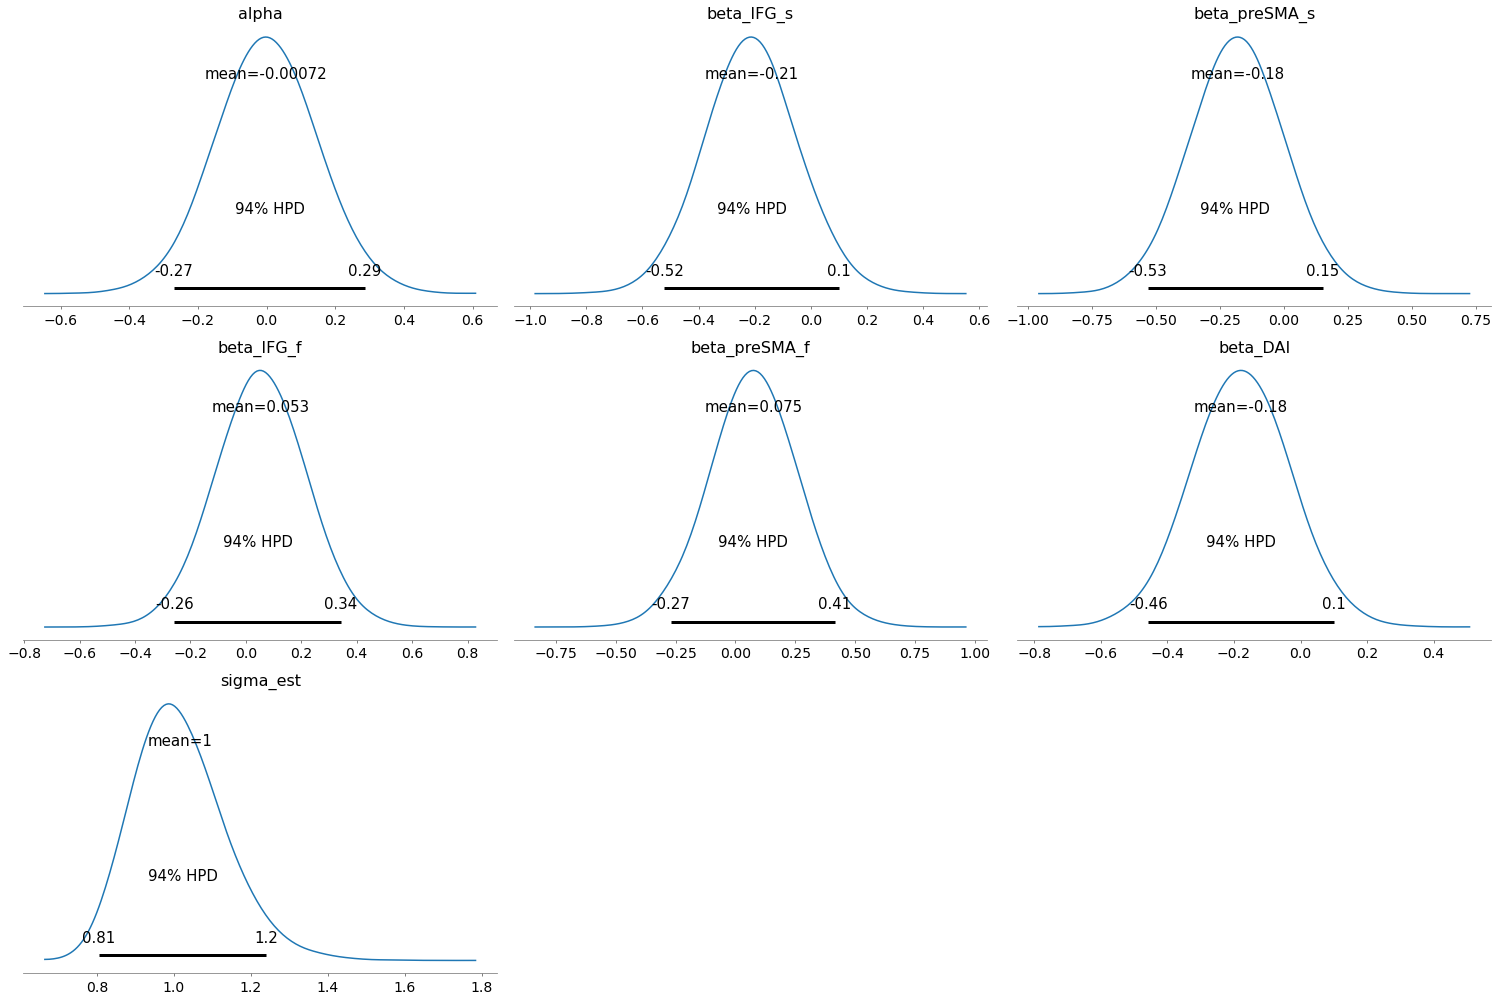

In [39]:
with MEG_multi:
    az.plot_posterior(trace)

In [40]:
with MEG_multi:
    ppc = pm.sample_posterior_predictive(
        trace, var_names=["alpha","beta_IFG_s","beta_preSMA_s","beta_IFG_f","beta_preSMA_f",
                         "beta_DAI","sigma_est","SSR_z_modeled" ], random_seed=42)

100%|██████████| 40000/40000 [00:52<00:00, 763.29it/s]


In [42]:
# visualize this with arviz
with MEG_multi:
    idata = az.from_pymc3( posterior_predictive=ppc) # import the data into arviz format
    az.plot_ppc(idata);

TypeError: `data` argument must have the group "observed_data" for ppcplot

In [43]:
idata

Inference data with groups:
	> posterior_predictive

<function matplotlib.pyplot.show(close=None, block=None)>

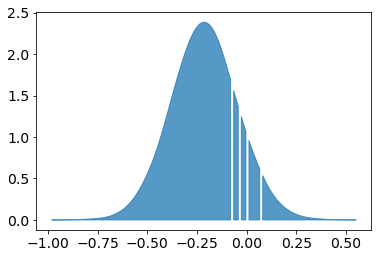

In [44]:
az.plot_kde(trace["beta_IFG_s"], quantiles=[0.8, 0.85, 0.90, 0.95])
plt.show

In [45]:
with MEG_multi:
    MEG_multi_loo = pm.loo(trace, MEG_multi)
MEG_multi_loo

Computed from 40000 by 43 log-likelihood matrix

       Estimate       SE
IC_loo   130.75    10.31
p_loo      6.40        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       40   93.0%
 (0.5, 0.7]   (ok)          3    7.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

### Model with all pairwise interaction terms
Note: If you are modeling interactions you may (or may not) consider to model higher order interactions, i.e. find the coefficients on products of more than two variables:

Model = ... + delta_uvw *u * v * w + ...

In [46]:
with pm.Model() as MEG_inter:
    alpha = pm.Normal("alpha", 0,0.5)
    beta_IFG_s = pm.Normal("beta_IFG_s", 0,0.5)
    beta_preSMA_s = pm.Normal("beta_preSMA_s",0,0.5)
    beta_IFG_f = pm.Normal("beta_IFG_f", 0,0.5)
    beta_preSMA_f = pm.Normal("beta_preSMA_f",0,0.5)
    beta_DAI = pm.Normal("beta_DAI", 0,0.5)
    sigma_est = pm.HalfNormal("sigma_est", sd = 1)
    
    # g = gamma interaction coefficient
    # I = IFG, pS = preSMA, s = success, f = fail
    g_Is_If = pm.Normal("g_Is_If",0,0.5)
    g_Is_pSs = pm.Normal("g_Is_pSs",0,0.5)
    g_Is_pSf = pm.Normal("g_Is_pSf",0,0.5)
    g_Is_DAI = pm.Normal("g_Is_DAI",0,0.5)
    g_pSs_If = pm.Normal("g_pSs_If",0,0.5)
    g_pSs_pSf = pm.Normal("g_pSs_pSf",0,0.5)
    g_pSs_DAI = pm.Normal("g_pSs_DAI",0,0.5)
    g_If_pSf = pm.Normal("g_If_pSf",0,0.5)
    g_If_DAI = pm.Normal("g_If_DAI",0,0.5)
    g_pSf_DAI = pm.Normal("g_pSf_DAI",0,0.5)
    
    
    SSRT_z_deterministic = (alpha
                          + beta_IFG_s * Beta_rIFG_success_z
                          + beta_preSMA_s * Beta_preSMA_success_z
                          + beta_IFG_f * Beta_rIFG_fail_z
                          + beta_preSMA_f * Beta_preSMA_fail_z
                          + beta_DAI * DAI_z
                          + g_Is_If * Beta_rIFG_success_z * Beta_rIFG_fail_z
                          + g_Is_pSs * Beta_rIFG_success_z * Beta_preSMA_success_z
                          + g_Is_pSf * Beta_rIFG_success_z * Beta_preSMA_fail_z
                          + g_Is_DAI * Beta_rIFG_success_z * DAI_z
                          + g_pSs_If * Beta_preSMA_success_z * Beta_rIFG_fail_z
                          + g_pSs_pSf * Beta_preSMA_success_z * Beta_preSMA_fail_z
                          + g_pSs_DAI * Beta_preSMA_success_z * DAI_z
                          + g_If_pSf * Beta_rIFG_fail_z * Beta_preSMA_fail_z
                          + g_If_DAI * Beta_rIFG_fail_z * DAI_z
                          + g_pSf_DAI * Beta_preSMA_fail_z * DAI_z)
    
    SSR_z_modeled = pm.Normal("SSR_z_modeled", mu = SSRT_z_deterministic, sigma = sigma_est, observed = SSRT_z)  
    

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [g_pSf_DAI, g_If_DAI, g_If_pSf, g_pSs_DAI, g_pSs_pSf, g_pSs_If, g_Is_DAI, g_Is_pSf, g_Is_pSs, g_Is_If, sigma_est, beta_DAI, beta_preSMA_f, beta_IFG_f, beta_preSMA_s, beta_IFG_s, alpha]
Sampling 2 chains, 0 divergences: 100%|██████████| 44000/44000 [02:31<00:00, 290.98draws/s]
/Users/mb/opt/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/mb/opt/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/mb/opt/anaconda3/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotl

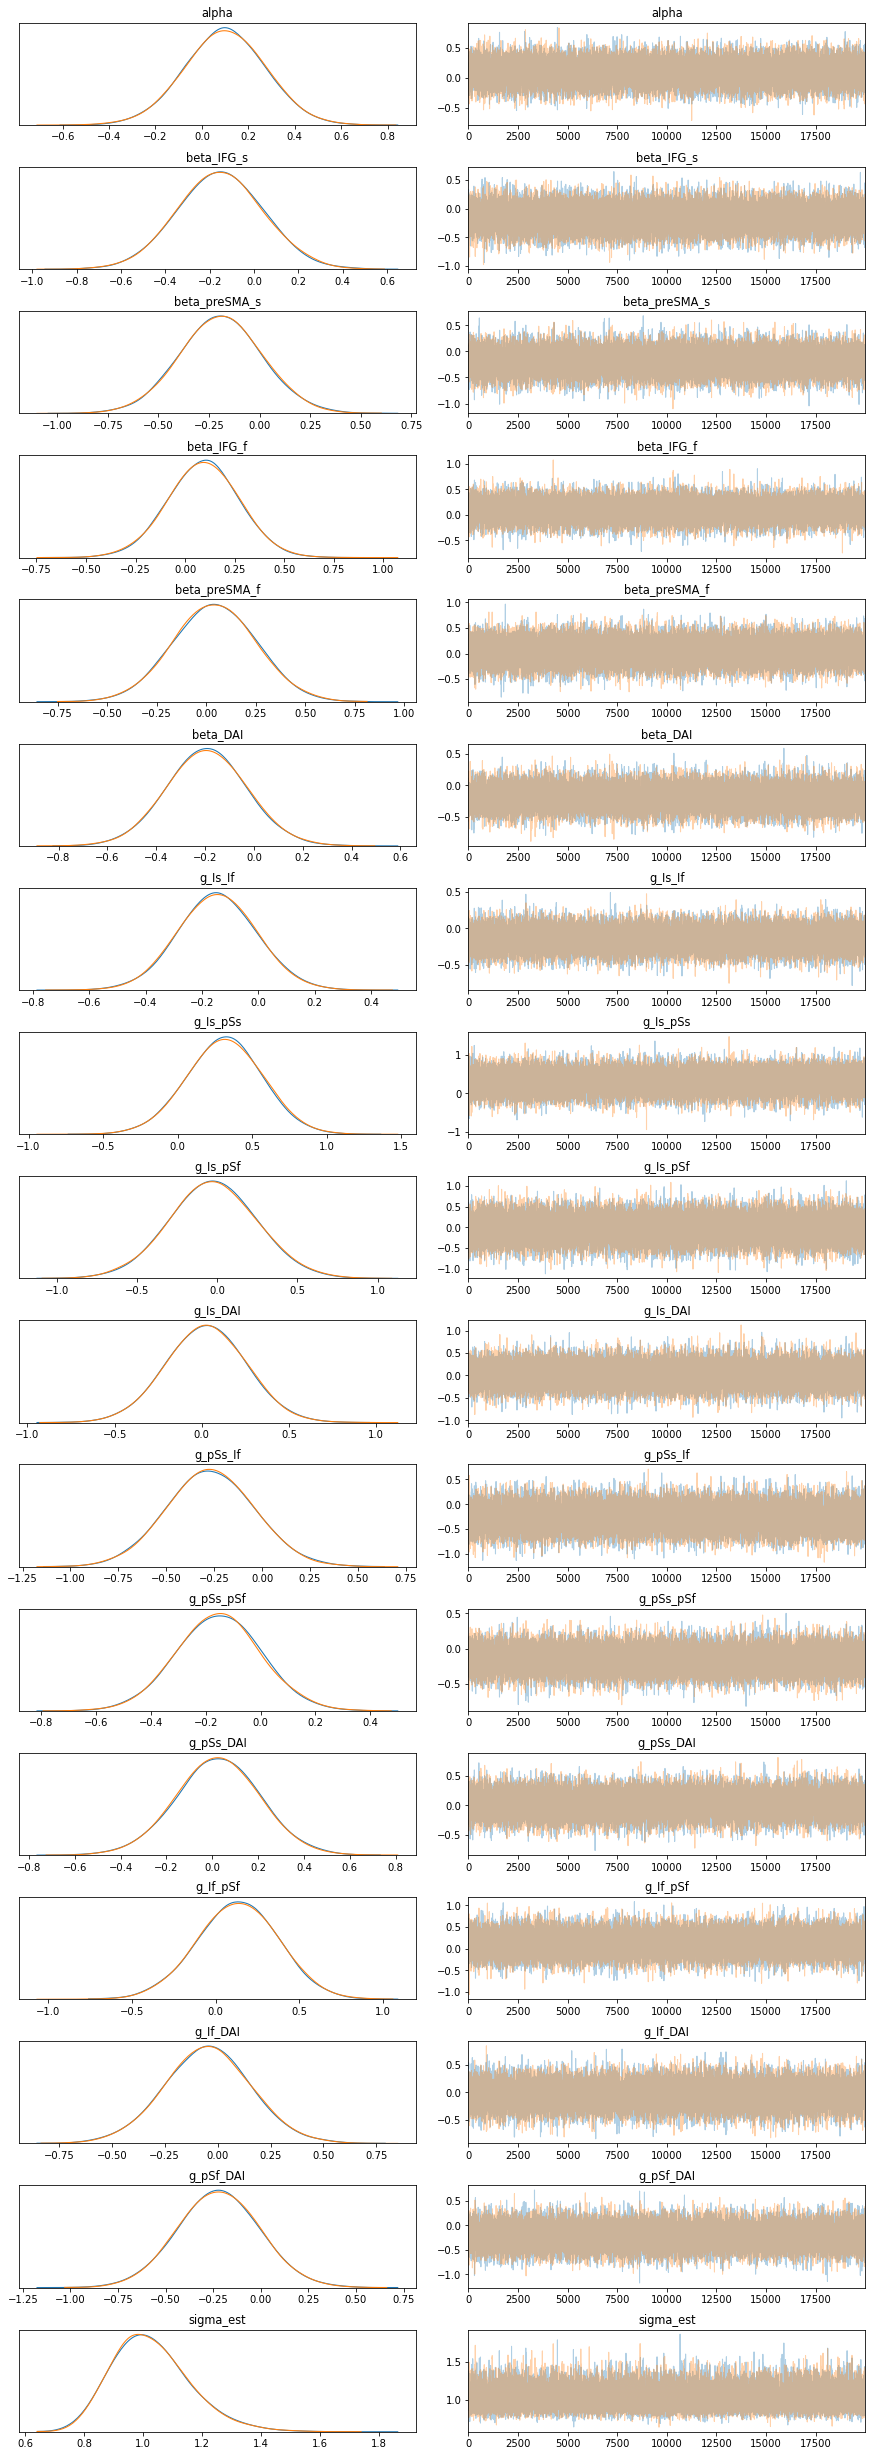

In [47]:
with MEG_inter:
    trace_i = pm.sample(20000, tune=2000, init="adapt_diag")
    az.plot_trace(trace_i);   

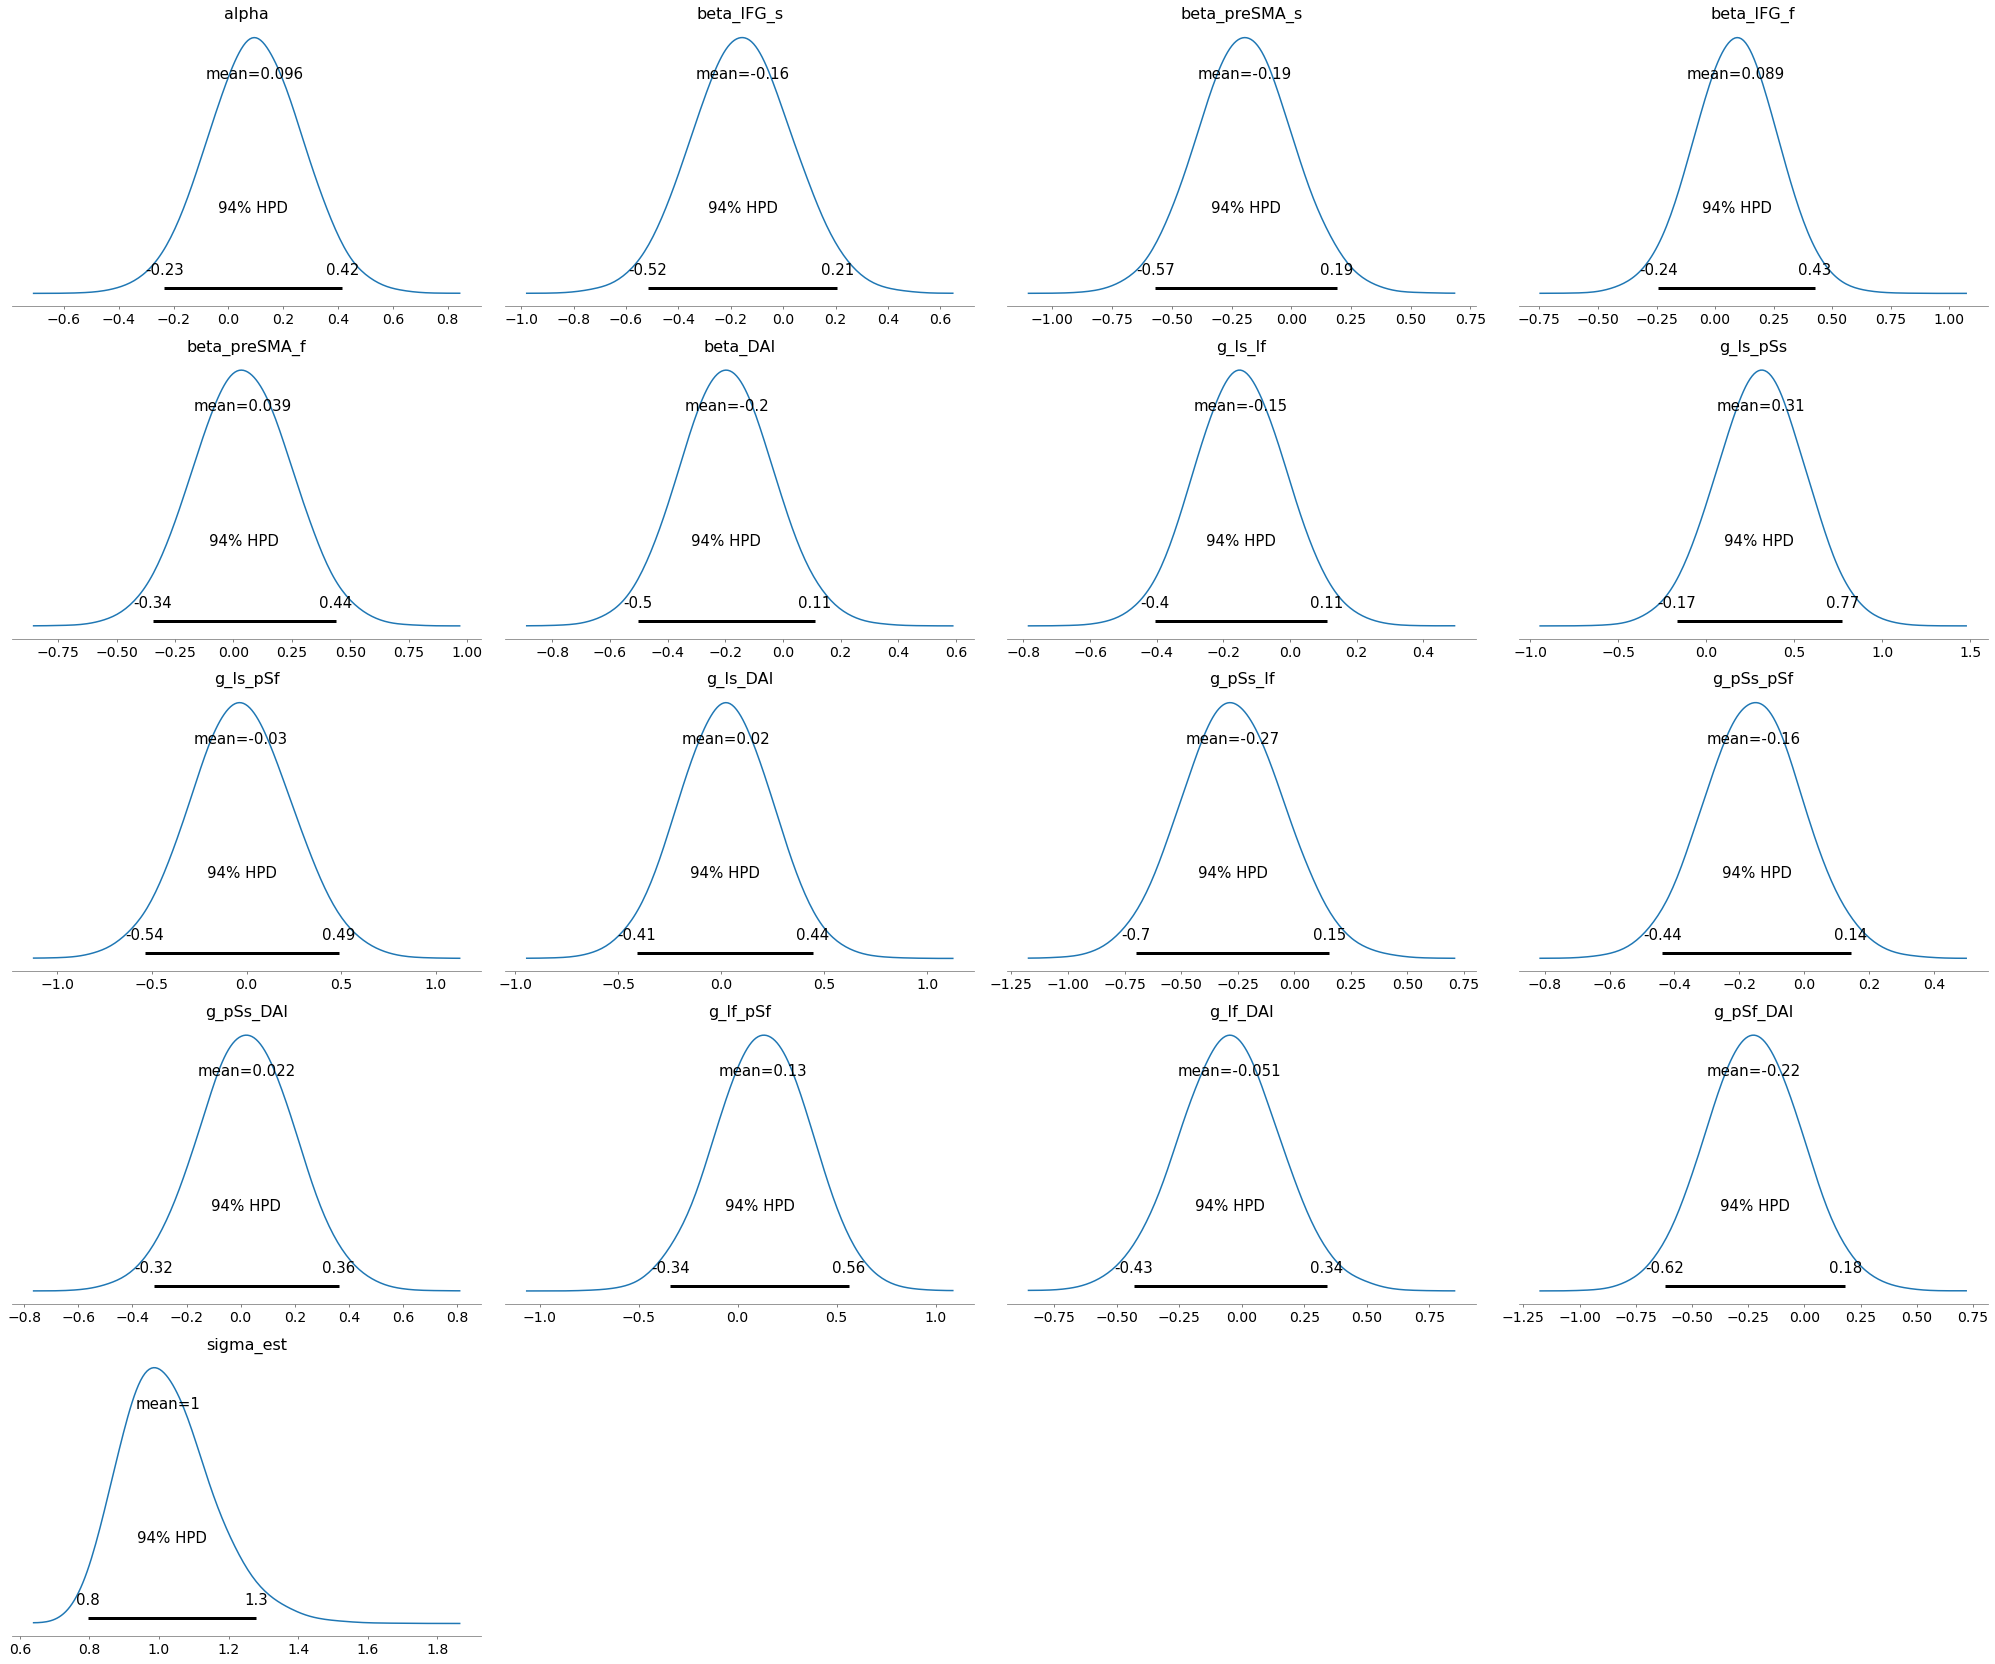

In [51]:
with MEG_inter:
    az.plot_posterior(trace_i)

In [52]:
with MEG_inter:
    MEG_inter_loo = pm.loo(trace_i, MEG_inter)

/Users/mb/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:526: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [53]:
MEG_inter_loo

Computed from 40000 by 43 log-likelihood matrix

       Estimate       SE
IC_loo   143.25     9.03
p_loo     13.92        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       31   72.1%
 (0.5, 0.7]   (ok)          8   18.6%
   (0.7, 1]   (bad)         4    9.3%
   (1, Inf)   (very bad)    0    0.0%

In [54]:
with MEG_multi:
    posterior_idata_inter = az.from_pymc3(trace_i)
posterior_idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [55]:
fraction_negative(posterior_idata_inter,"beta_IFG_s")

Fraction of negative samples for beta_IFG_s is 0.79195


0.79195

In [56]:
fraction_negative(posterior_idata_inter,"beta_IFG_f")

Fraction of negative samples for beta_IFG_f is 0.3047


0.3047

In [57]:
fraction_negative(posterior_idata_inter,"beta_preSMA_s")

Fraction of negative samples for beta_preSMA_s is 0.8379


0.8379

In [58]:
fraction_negative(posterior_idata_inter,"beta_preSMA_f")

Fraction of negative samples for beta_preSMA_f is 0.42395


0.42395